In [ ]:
# 必要なパッケージをインストール
!pip install torch pandas numpy matplotlib seaborn


ストリーミング出力は最後の 5000 行に切り捨てられました。
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
Epoch 2872/3000, Batch 30, Loss: 0.0000
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
Epoch 2872/3000, Average Loss: 0.0000
attention_per_position.shape: torch.Size([32, 100])
Epoch 2873/3000, Batch 0, Loss: 0.0000
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_position.shape: torch.Size([32, 100])
attention_per_posit

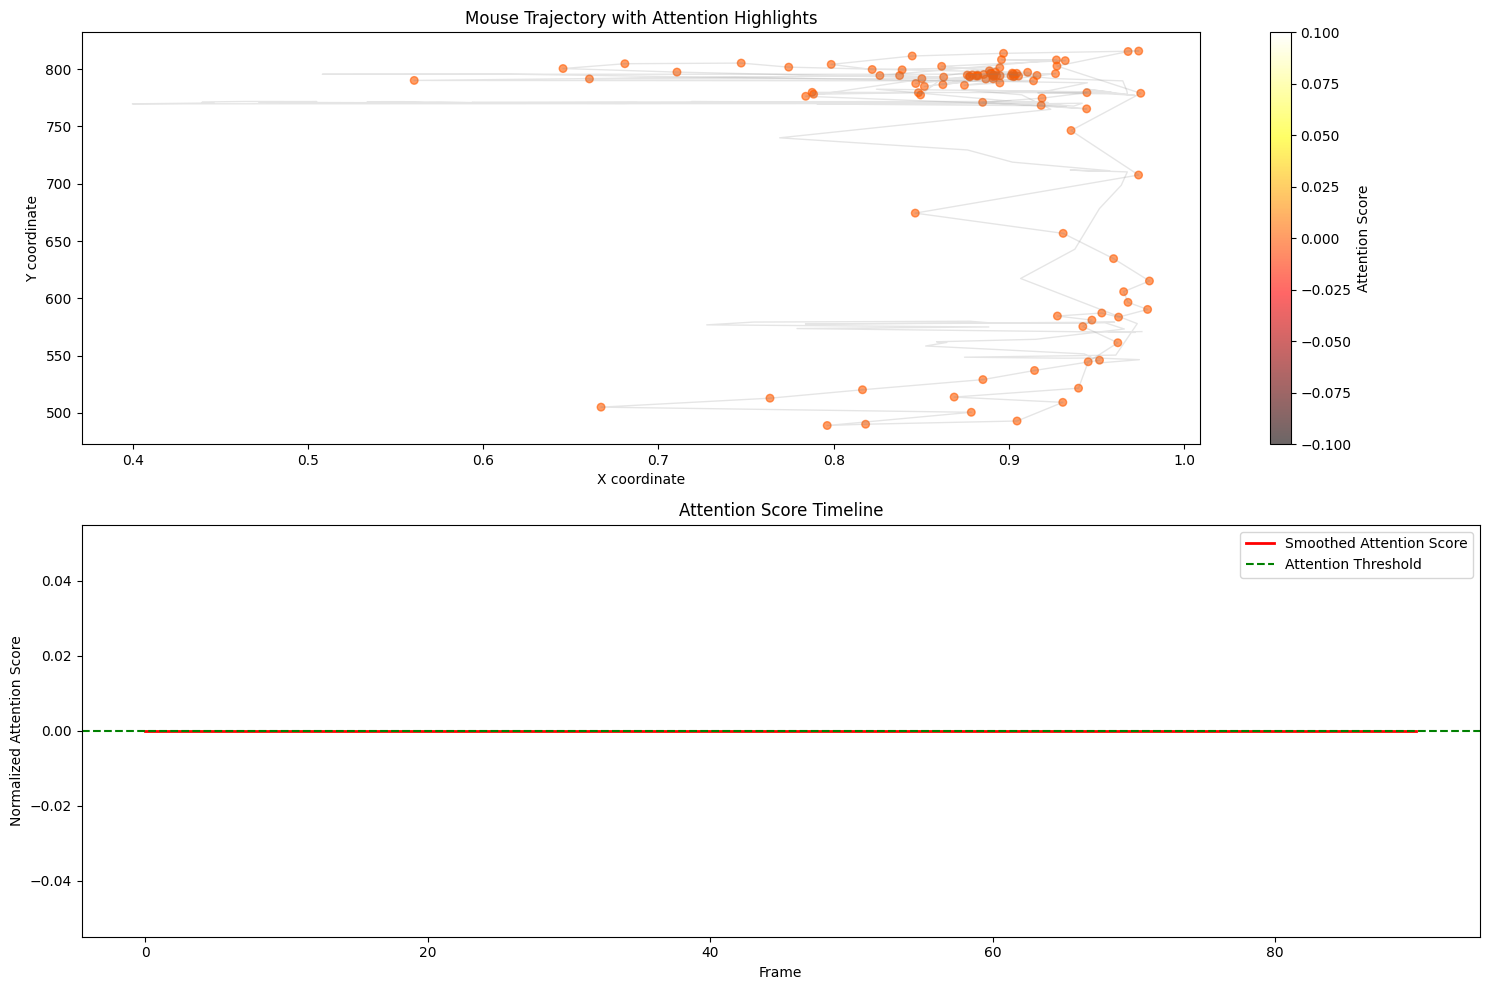

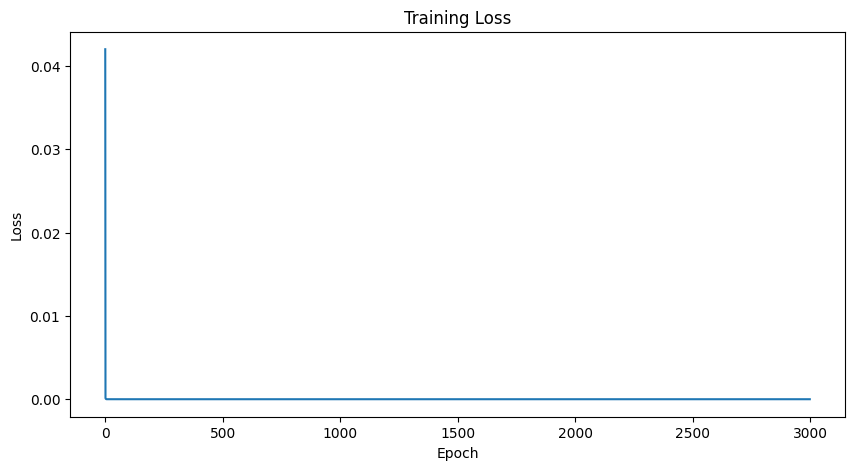

解析が正常に完了しました！


In [ ]:
# 必要なライブラリのインポート
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import os
import warnings
warnings.filterwarnings('ignore')
import copy

# Google Driveをマウント
drive.mount('/content/drive', force_remount=True)

class MouseTrajectoryDataset(Dataset):
    def __init__(self, csv_path, sequence_length=100):
        print(f"CSVファイルからデータをロードしています: {csv_path}")

        # CSVファイルを読み込み
        self.df = pd.read_csv(csv_path, skiprows=[2])
        print("元のCSVの形状:", self.df.shape)
        print("利用可能なカラム:", self.df.columns.tolist())

        # x座標とy座標のカラムを特定
        x_cols = [col for col in self.df.columns if col.endswith('.2') or
                 col.endswith('.5') or col.endswith('.8')]
        y_cols = [col for col in self.df.columns if col.endswith('.3') or
                 col.endswith('.6') or col.endswith('.9')]

        # 座標データを抽出
        coord_data = []
        for x_col, y_col in zip(x_cols, y_cols):
            x_data = pd.to_numeric(self.df[x_col], errors='coerce')
            y_data = pd.to_numeric(self.df[y_col], errors='coerce')
            coord_data.extend([x_data.values, y_data.values])

        # データをnumpy配列に変換
        self.data = np.stack(coord_data, axis=1)
        print("座標データの形状:", self.data.shape)

        # 特徴量計算
        self.features = self._calculate_features()
        print("特徴量の形状:", self.features.shape)

        self.sequence_length = sequence_length
        self.sequences = self._create_sequences()
        print(f"シーケンスの数: {len(self.sequences)}")

    def _calculate_features(self):
        n_frames = len(self.data)
        n_coords = self.data.shape[1]

        # 速度計算
        velocity = np.zeros_like(self.data)
        velocity[1:] = self.data[1:] - self.data[:-1]
        speed = np.sqrt(np.sum(np.reshape(velocity, (n_frames, -1, 2))**2, axis=2))

        # 加速度計算
        acceleration = np.zeros_like(velocity)
        acceleration[1:] = velocity[1:] - velocity[:-1]
        acc_magnitude = np.sqrt(np.sum(np.reshape(acceleration, (n_frames, -1, 2))**2, axis=2))

        # 角度計算
        body_direction = np.zeros((n_frames, velocity.shape[1]//2))
        if n_frames > 1:
            velocity_reshaped = np.reshape(velocity, (n_frames, -1, 2))
            body_direction[1:] = np.arctan2(velocity_reshaped[1:, :, 1],
                                          velocity_reshaped[1:, :, 0])

        # 特徴量を結合
        features = np.concatenate([
            self.data,  # 元の座標
            speed,  # 速度
            acc_magnitude,  # 加速度
            body_direction,  # 角度
        ], axis=1)

        # NaNを処理
        features = np.nan_to_num(features, nan=0.0)

        # 正規化
        features_mean = np.mean(features, axis=0)
        features_std = np.std(features, axis=0)
        features_std[features_std == 0] = 1
        features = (features - features_mean) / features_std

        return features

    def _create_sequences(self):
        sequences = []
        for i in range(0, len(self.features) - self.sequence_length + 1):
            sequence = self.features[i:(i + self.sequence_length)]
            sequences.append(sequence)
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx])

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Positional Encodingの計算
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        pe = self.pe[:x.size(1), :].unsqueeze(0)  # [1, seq_len, d_model]
        x = x + pe
        return x

class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(
            d_model, nhead, dropout=dropout, batch_first=True
        )
        # フィードフォワードネットワーク
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = F.relu  # またはF.gelu

    def forward(self, src):
        # src: [batch_size, seq_len, d_model]
        src2, attn_weights = self.self_attn(
            src, src, src, need_weights=True, average_attn_weights=False
        )
        # attn_weights: [batch_size, num_heads, seq_len, seq_len]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn_weights

class CustomTransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(CustomTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])
        self.num_layers = num_layers

    def forward(self, src):
        # src: [batch_size, seq_len, d_model]
        output = src
        attentions = []
        for mod in self.layers:
            output, attn_weights = mod(output)
            attentions.append(attn_weights)
        return output, attentions

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes=1, d_model=128, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1):
        super().__init__()
        print(f"Creating Transformer model with input_dim={input_dim}, d_model={d_model}")

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = CustomTransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = CustomTransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        x = self.feature_extractor(x)  # [batch_size, seq_len, d_model]
        x = self.pos_encoder(x)  # [batch_size, seq_len, d_model]
        # xを[batch_size, seq_len, d_model]のままにする（batch_first=True）
        output, attentions = self.transformer_encoder(x)  # output: [batch_size, seq_len, d_model]
        # シーケンス長で平均
        x = output.mean(dim=1)  # [batch_size, d_model]
        output = self.classifier(x)  # [batch_size, num_classes]
        return output, attentions  # attentionsは各層のアテンションウェイトのリスト

def train_model(model, train_loader, num_epochs=3000, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    history = {'loss': [], 'attention_patterns': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, sequences in enumerate(train_loader):
            sequences = sequences.to(device)

            optimizer.zero_grad()
            outputs, attentions = model(sequences)

            # アテンションスコアの計算
            attention_scores = torch.stack(attentions, dim=0)  # [num_layers, batch_size, num_heads, seq_len, seq_len]
            attention_scores = attention_scores.mean(dim=2)  # ヘッド間平均 -> [num_layers, batch_size, seq_len, seq_len]
            attention_scores = attention_scores.mean(dim=0)  # 層間平均 -> [batch_size, seq_len, seq_len]
            attention_per_position = attention_scores.sum(dim=-1)  # [batch_size, seq_len]

            # 形状の確認
            print(f"attention_per_position.shape: {attention_per_position.shape}")

            # ターゲットの生成
            target = torch.zeros_like(outputs)
            threshold = attention_per_position.mean(dim=1, keepdim=True) + attention_per_position.std(dim=1, keepdim=True)
            mask = (attention_per_position > threshold).any(dim=1).float()
            target = mask.unsqueeze(1)

            loss = criterion(outputs, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        history['loss'].append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

        # エポックごとにモデルを保存（オプション）
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f'/content/drive/MyDrive/model_epoch_{epoch+1}.pth')

    return history

def visualize_results(dataset, attention_scores, save_path=None):
    plt.figure(figsize=(15, 10))

    # データの準備
    n_coords = dataset.data.shape[1] // 2
    coords = dataset.data.reshape(-1, n_coords, 2)
    attention_normalized = attention_scores.squeeze()

    # データの長さを合わせる
    min_length = min(len(coords), len(attention_normalized))
    coords = coords[:min_length]
    attention_normalized = attention_normalized[:min_length]

    # 正規化
    attention_normalized = (attention_normalized - attention_normalized.min()) / \
                         (attention_normalized.max() - attention_normalized.min() + 1e-8)

    # 軌跡プロット
    plt.subplot(2, 1, 1)

    # 全体の軌跡を薄く表示
    for i in range(n_coords):
        plt.plot(coords[:, i, 0], coords[:, i, 1],
                alpha=0.2, color='gray', linewidth=1)

    # アテンションスコアでカラーマッピング
    scatter = plt.scatter(coords[:, 0, 0], coords[:, 0, 1],
                         c=attention_normalized,
                         cmap='hot',
                         s=30,
                         alpha=0.6)

    plt.colorbar(scatter, label='Attention Score')
    plt.title('Mouse Trajectory with Attention Highlights')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')

    # 時系列プロット
    plt.subplot(2, 1, 2)

    # 移動平均の計算
    window_size = 10
    smoothed_attention = np.convolve(attention_normalized,
                                   np.ones(window_size)/window_size,
                                   mode='valid')

    # 時系列データのプロット
    time_points = np.arange(len(smoothed_attention))
    plt.plot(time_points, smoothed_attention, 'r-',
            label='Smoothed Attention Score', linewidth=2)

    # 閾値線の追加
    threshold = attention_normalized.mean() + attention_normalized.std()
    plt.axhline(y=threshold, color='g', linestyle='--',
               label='Attention Threshold')

    # ハイライト領域の表示
    high_attention_mask = smoothed_attention > threshold
    for start, end in get_continuous_segments(high_attention_mask):
        plt.axvspan(start, end, color='yellow', alpha=0.3)

    plt.title('Attention Score Timeline')
    plt.xlabel('Frame')
    plt.ylabel('Normalized Attention Score')
    plt.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def get_continuous_segments(mask):
    """連続した区間を取得する補助関数"""
    segments = []
    start = None

    for i, val in enumerate(mask):
        if val and start is None:
            start = i
        elif not val and start is not None:
            segments.append((start, i))
            start = None

    if start is not None:
        segments.append((start, len(mask)))

    return segments

def main():
    # ファイルパスの設定
    file_path = 'DeepLabCutのcsvパス'

    try:
        # データセットの作成
        dataset = MouseTrajectoryDataset(file_path, sequence_length=100)

        # データローダーの設定
        batch_size = 32
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=0
        )

        # データの形状を確認
        for batch in dataloader:
            print(f"バッチの形状: {batch.shape}")
            break

        # モデルの作成
        input_dim = dataset.features.shape[1]
        model = TransformerModel(input_dim=input_dim, d_model=128, nhead=8, num_layers=4)

        # データとモデルの形状確認
        for batch in dataloader:
            outputs, attentions = model(batch)
            print(f"入力の形状: {batch.shape}")
            print(f"出力の形状: {outputs.shape}")
            print(f"Attentionの数: {len(attentions)}")
            print(f"attentions[0].shape: {attentions[0].shape}")
            break

        # モデルの訓練
        history = train_model(model, dataloader, num_epochs=3000)

        # 結果の可視化
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        with torch.no_grad():
            model.eval()
            all_attention = []
            for sequences in dataloader:
                sequences = sequences.to(device)
                _, attentions = model(sequences)
                # アテンションスコアの計算
                attention_scores = torch.stack(attentions, dim=0)  # [num_layers, batch_size, num_heads, seq_len, seq_len]
                attention_scores = attention_scores.mean(dim=2)  # ヘッド間平均 -> [num_layers, batch_size, seq_len, seq_len]
                attention_scores = attention_scores.mean(dim=0)  # 層間平均 -> [batch_size, seq_len, seq_len]
                attention_per_position = attention_scores.sum(dim=-1)  # [batch_size, seq_len]
                all_attention.append(attention_per_position.cpu().numpy())

            average_attention = np.concatenate(all_attention, axis=0).mean(axis=0)
            visualize_results(dataset, average_attention,
                             '/content/drive/MyDrive/mouse_behavior_analysis.png')

        # 学習曲線の描画
        plt.figure(figsize=(10, 5))
        plt.plot(history['loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('/content/drive/MyDrive/training_loss.png')
        plt.show()

        print("解析が正常に完了しました！")

    except Exception as e:
        print(f"エラーが発生しました: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()
